# Line Tracing #

## Idea ##

Function: Main
1) Load 1 pixel Image
2) Give every pixel a id
3) Select a Starting Point
Function: Trace Line
1) Check all Pixels surrounding the Starting Point

In [1]:
import utils
import matplotlib.pyplot as plt
import igraph as g
import json
import math as m
import cv2

from utils import getPixel,colorPixels,isOneColor
from constants import *

In [2]:
imageArray = utils.load1Pixel("./../src/testImages","3.png",binary=True)
colorImage = utils.load1Pixel("./../src/testImages","3.png",color=True)

end reached


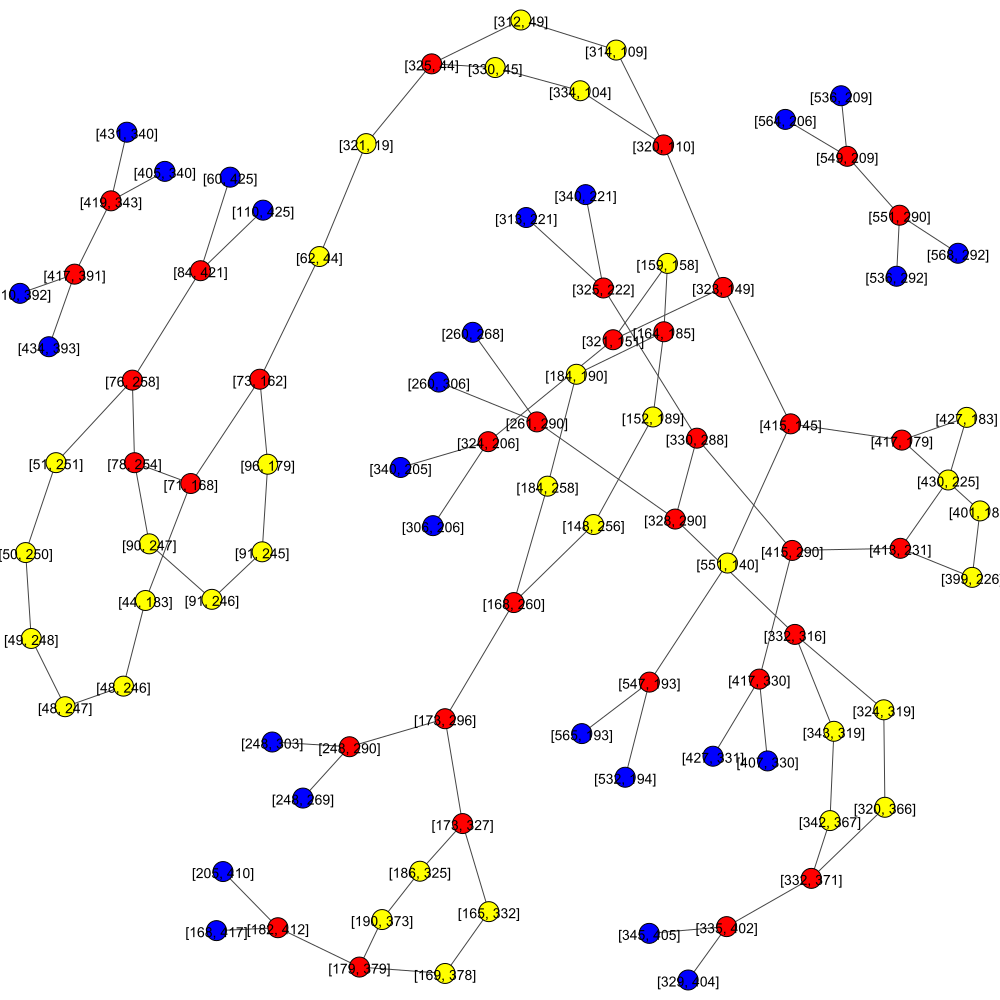

In [3]:
# Returns all Adjacent Pixels with a specific color
# image             -> 2D array with Pixel values
# pixel             -> coordinates of the pixel the others should be ajacent to
# color             -> the color of the "wanted" pixels
# blacklist         -> These pixels get ignored
def getAdjacentPixel(image,pixel,color,blacklist=[]):    
    adjacentPixels = [[-1,-1],[0,-1],[1,-1], \
                        [-1,0],        [1,0], \
                        [-1,1], [0,1], [1,1]]
    #create a array with the coordinates of all adjacentPixels
    validPixels = ([ pixel[0]+adj[0], pixel[1]+adj[1] ] for adj in adjacentPixels)
    #filter all pixels that are not the right color
    validPixels = list(
        filter(lambda coords: getPixel(image,coords) == color,validPixels)
    )
    #filter all pixels that are in the blacklist
    validPixels = list(
        filter(lambda x: not x in blacklist, validPixels)
    )

    return validPixels

# returns the coordinates of the first <color> pixel it finds
def findStaringPoint(image,color):
    for y in range(0,len(image)):
        for x in range(0,len(image[y])):
            if getPixel(image,x,y) == color:
                return [x,y]

# Runs along line until it finds the first Intersection
#
# image      -> The image
# startPoint -> Any random Point on the line
# color      -> The color of the Line
def findFirstIntersection(image,startPoint,color):

    def recursiveFindValidPoint(currentPixel,lastPixel,dir):
        adjacentPixels = getAdjacentPixel(image,currentPixel,color)
        if len(adjacentPixels) > 2:
            return currentPixel
        elif len(adjacentPixels) == 1:
            return recursiveFindValidPoint(adjacentPixels[dir],currentPixel,-1)
        else:
            adjacentPixels = getAdjacentPixel(image,currentPixel,color,[lastPixel]) 
            return recursiveFindValidPoint(adjacentPixels[dir],currentPixel,dir)
    return recursiveFindValidPoint(startPoint,None,0)


# image -> binary image
# startingPoint -> tuple with the starting coords
# color -> the color of the foreground Pixels
def generatePartGraph(image,startPoint,color):
    #init recustion
    visitedCoords = []
    #count
    graph = g.Graph(directed=False)

    #add the starting Vector
    graph.add_vertex(str(startPoint), label=str(startPoint) ,color=INTERSECTION_COLOR,coordinate=tuple(startPoint))

    # recursive Function
    # currentCoord -> the coordinate of the current pixel
    # lastCoords -> the coordinates of the last visited pixels
    # lastVertexName -> name of the last added Vertex                                                           |------ knows only about verticies in this branch
    # dirGradient -> a list of all the directional steps the function took: 1->horizontal,0->vertical       ----|
    def recursiveGenerateGraph(currentCoord,lastCoords,lastVertexName,dirGradient):       #                     |------ knows only about verticies in this branch

        # start by creating an independent copy of the dirGradient list
        newDirGradient = list(dirGradient)

        #get the new directional Step
        # 1 = horizontal
        # 0 = vertical
        if(abs(currentCoord[0] - lastCoords[0]) < abs(currentCoord[1] - lastCoords[1])):
            newDirGradient.append(1)
        else:
            newDirGradient.append(0)

        # If the currentCoordinate has already been visited, this means a loop hast benn closed and you have to create a connection
        # from the last Vertex to this Vertex -> end recursion
        if currentCoord in visitedCoords:
            # check if the currentCoordinate has even a Vertex in the graph
            if len(graph.vs.select(name=str(currentCoord))):
                graph.add_edge(lastVertexName,str(currentCoord))
            return
        
        # add the current Cooridante to the visited Cooridantes
        visitedCoords.append(currentCoord)

        # get the adjacent Pixels to the current one
        adjacentPixels = getAdjacentPixel(image,currentCoord,color,[lastCoords])

        # if there are no more adjacent Pixels
        if len(adjacentPixels) == 0:
            #ENDPOINT

            # to prevent self Loop
            if(str(currentCoord) != lastVertexName):
                graph.add_vertex(str(currentCoord),label=str(currentCoord),color=END_COLOR,coordinate=tuple(currentCoord))
                # connect lastVertexId to the just added Vertex

                graph.add_edge(lastVertexName,str(currentCoord))
        
        #if there is exactly one adjacent Pixel
        elif len(adjacentPixels) == 1:
            #LINE

            # check if the dir Gradent is longer then 6 -> otherwhise ignore dir changes and recursive call
            if len(newDirGradient) > 6:

                # calculate the current dir by taking the last 4 elements and avaraging them
                currDire = sum(newDirGradient[-4:])/4 < 0.5
                # calcualte the newDirGradient dir by taking the 4 elements form the 5 least to the second least and avaraging them
                lastDire = sum(newDirGradient[-5:-1])/4 < 0.5
                # if the direction changed add a new corner vertex else just recursive call the function
                if not  currDire == lastDire:
                    # to prevent self Loop
                    graph.add_vertex(str(currentCoord),label=str(currentCoord),color=CORNER_COLOR,coordinate=tuple(currentCoord))
                    graph.add_edge(lastVertexName,str(currentCoord))
                    recursiveGenerateGraph(adjacentPixels[0],currentCoord,str(currentCoord),newDirGradient)
                else:
                    recursiveGenerateGraph(adjacentPixels[0],currentCoord,lastVertexName,newDirGradient)
            else:
                recursiveGenerateGraph(adjacentPixels[0],currentCoord,lastVertexName,newDirGradient)

        else:
            #INTERSECTION

            # to prevent self Loop
            if(str(currentCoord) != lastVertexName):
                # to prevent self Loop
                graph.add_vertex(str(currentCoord),label=str(currentCoord),color=INTERSECTION_COLOR,coordinate=tuple(currentCoord))
                graph.add_edge(lastVertexName,str(currentCoord))
            #for every line going out of the intersection recursive call
            for adjacentPixel in adjacentPixels:
                recursiveGenerateGraph(adjacentPixel,currentCoord,str(currentCoord),[])
            
    recursiveGenerateGraph(startPoint,[0,0],str(startPoint),[])
    return graph,visitedCoords

def generateWholeGraph(image,foregroundColor,backgroundColor):
    graphCollection = []
    while True:
        startingPoint = findStaringPoint(image,foregroundColor)
        if(startingPoint):
            startingPoint = findFirstIntersection(image,startingPoint,foregroundColor)
            G,visitedPixels = generatePartGraph(image,startingPoint,foregroundColor)
            graphCollection.append(G)
            #Remove all visited Pixels
            image = colorPixels(image,visitedPixels,backgroundColor)
            if isOneColor(image,backgroundColor):
                print("end reached")
                break
        else:
            print("stoped before end")
            break

    return g.union(graphCollection)

union = generateWholeGraph(imageArray,FOREGROUND,BACKGROUND)
union.write("out3.graph",format="graphml")

layout = union.layout("fr")
g.plot(union, layout=layout,bbox = (1000,1000))

#### Pattern detection

In [4]:
def getColorListNode(graph):
    colorList = []
    for vert in graph.vs:
        if vert["color"] == "red":
            colorList.append(0)
        elif vert["color"] == "blue":
            colorList.append(1)
        elif vert["color"] == "yellow":
            colorList.append(2)
        elif vert["color"] == "white":
            colorList.append(3)
    return colorList

def getColorListEdge(graph):
    colorList = []
    for edge in graph.es:
        try:
            if edge["color"] == "red":
                colorList.append(1)
            elif edge["color"] == "blue":
                colorList.append(2)
            elif edge["color"] == "yellow":
                colorList.append(3)
            elif edge["color"] == "white":
                colorList.append(4)
            elif edge["color"] == "green":
                colorList.append(5)
            else:
                colorList.append(0)
        except:
            colorList.append(0)
    return colorList

def getPatternMatches(graph,pattern,sort=False):
    mapings = graph.get_subisomorphisms_vf2(pattern,color1=getColorListNode(graph),color2=getColorListNode(pattern),edge_color1=getColorListEdge(graph),edge_color2=getColorListEdge(pattern))
    result = []
    for i in range(0,len(mapings),1):
        if(sort):
            result.append(sorted(list( map(lambda node:json.loads(union.vs.find(node)["label"]) ,mapings[i]) )))
        else:
            result.append(list( map(lambda node:json.loads(union.vs.find(node)["label"]) ,mapings[i]) ))

    #remove duplicated
    final = []
    for i in result:
        if i not in final:
            final.append(i)
    return final

def connectCapsTougehter(graph):
    ground = g.Graph(directed=False)
    ground.add_vertex(0,color="blue")
    ground.add_vertex(1,color="red")
    ground.add_vertex(2,color="blue")
    ground.add_edge(1,0)
    ground.add_edge(1,2)

    capMatches = getPatternMatches(graph,ground,False)
    for cap1Match in capMatches:
        cap1Coord = cap1Match[1]
        for cap2Match in capMatches:
            cap2Coord = cap2Match[1]
            if not cap2Coord == cap1Coord:
                if m.sqrt((cap2Coord[0] - cap1Coord[0])**2 + (cap2Coord[1] - cap1Coord[1])**2)  < 20:
                    #only if the two are not directly connected
                    numberOfNodesBetween = graph.shortest_paths_dijkstra(source=str(cap1Coord), target = str(cap2Coord), mode="all")[0][0]
                    if not numberOfNodesBetween == 1:
                        graph.vs.select(name=str(cap1Coord))['color'] = "white"
                        graph.vs.select(name=str(cap2Coord))['color'] = "white"
                        graph.add_edge(str(cap1Coord),str(cap2Coord),color="green")
                        break
    return graph

def groundPattern():
    ground = g.Graph(directed=False)
    ground.add_vertex(0,color="blue")
    ground.add_vertex(1,color="red")
    ground.add_vertex(2,color="blue")
    ground.add_edge(1,0)
    ground.add_edge(1,2)
    return ground

def capPattern():
    cap = g.Graph(directed=False)
    cap.add_vertex(0,color="blue")
    cap.add_vertex(1,color="white")
    cap.add_vertex(2,color="blue")
    cap.add_edge(1,0)
    cap.add_edge(1,2)

    cap.add_vertex(3,color="blue")
    cap.add_vertex(4,color="white")
    cap.add_vertex(5,color="blue")
    cap.add_edge(4,3)
    cap.add_edge(4,5)

    cap.add_edge(1,4, color="green")
    return cap

def resistorPattern():
    res = g.Graph(directed=False)
    res.add_vertex(0,color="red")
    res.add_vertex(1,color="yellow")
    res.add_vertex(2,color="yellow")
    res.add_vertex(3,color="red")
    res.add_vertex(4,color="yellow")
    res.add_vertex(5,color="yellow")
    res.add_edge(0,1)
    res.add_edge(1,2)
    res.add_edge(2,3)
    res.add_edge(3,4)
    res.add_edge(4,5)
    res.add_edge(5,0)
    return res

def generateBoundingBox(listOfCoords,offset):
    xCoords = list(map(lambda x: x[0],listOfCoords))
    yCoords = list(map(lambda y: y[1],listOfCoords))

    #get smalles and biggest of each and create Box
    from_ = [min(xCoords)-offset,min(yCoords)-offset]
    to_ = [max(xCoords)+offset,max(yCoords)+offset]
    return [from_,to_]


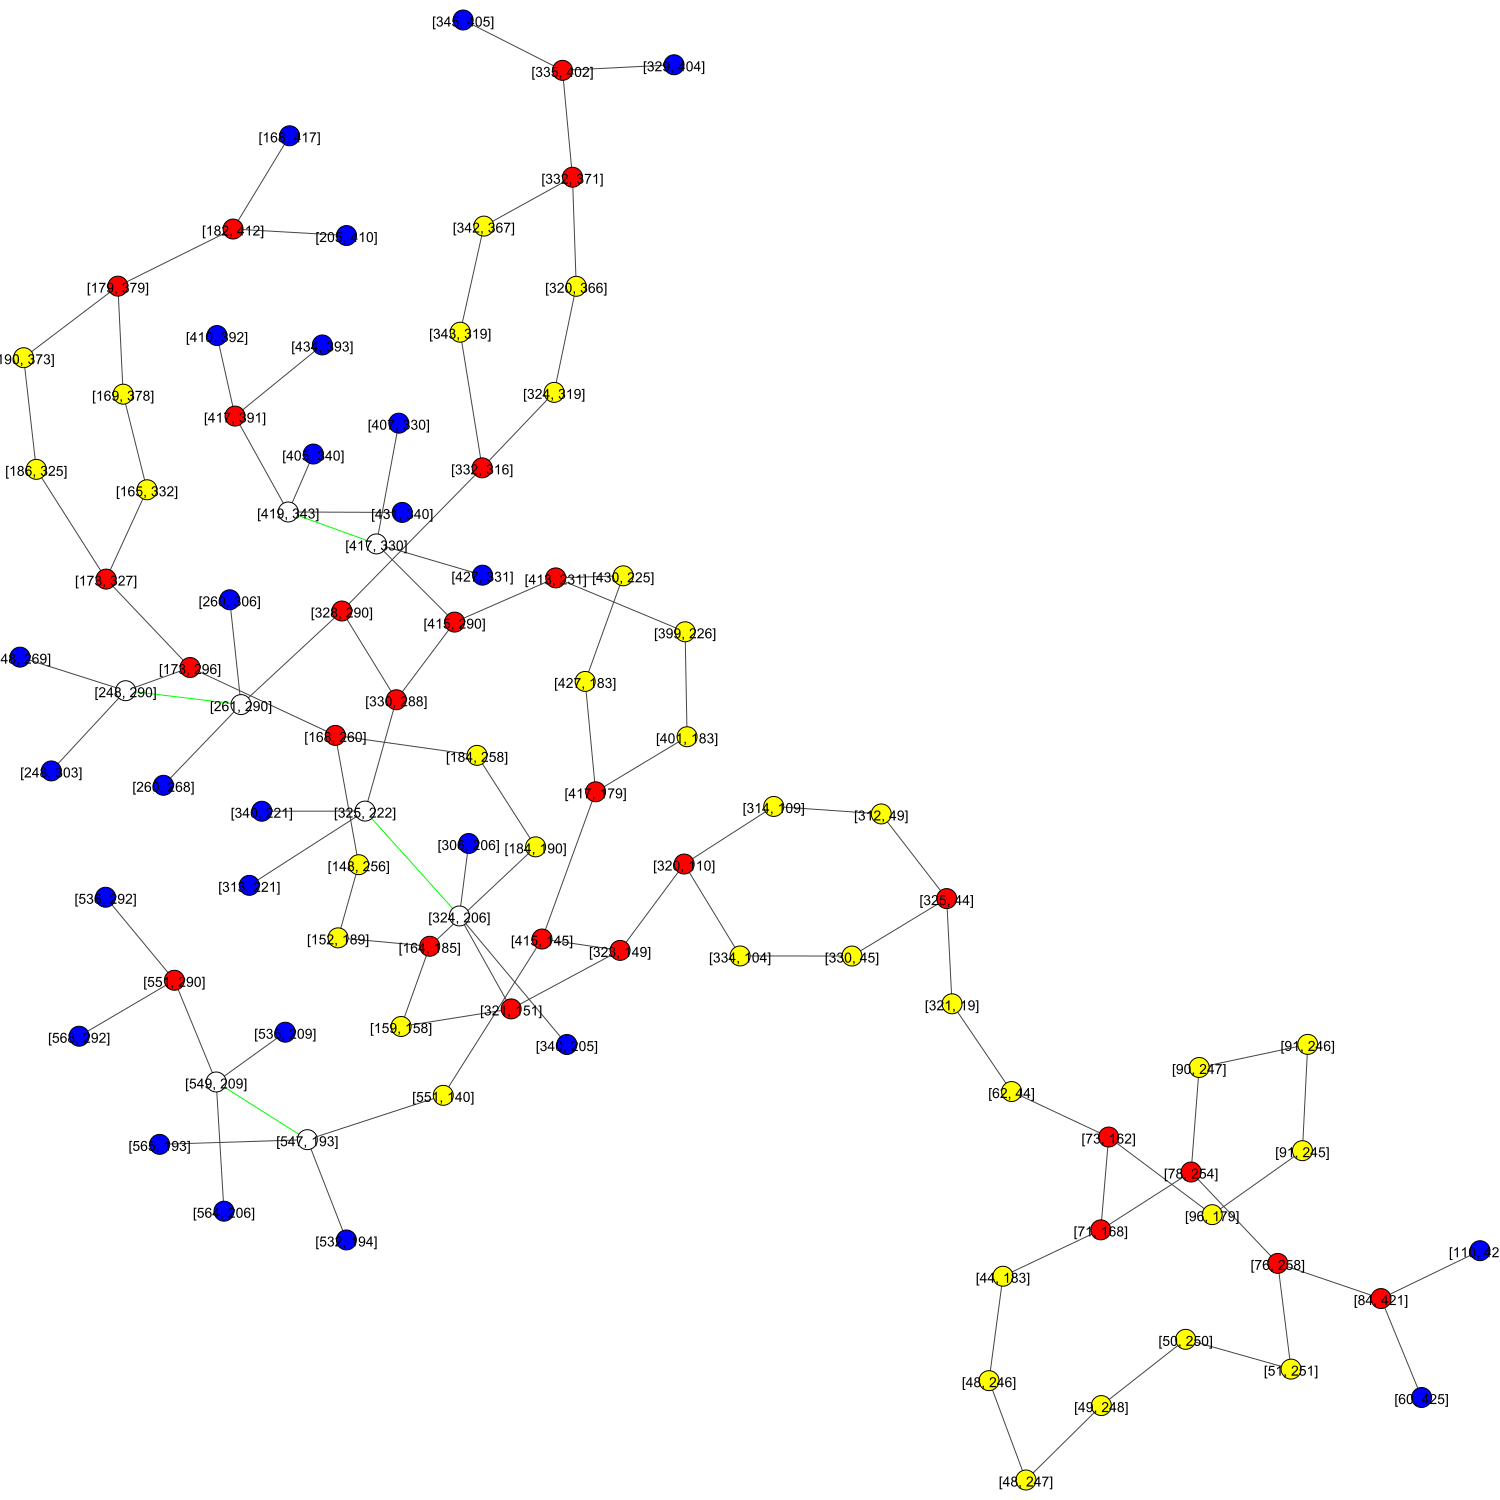

In [5]:
union = connectCapsTougehter(union)
layout = union.layout("large_graph")
g.plot(union, layout=layout,bbox=(1500, 1500))

[[[405, 340], [407, 330], [417, 330], [419, 343], [427, 331], [431, 340]], [[532, 194], [536, 209], [547, 193], [549, 209], [564, 206], [565, 193]], [[248, 269], [248, 290], [248, 303], [260, 268], [260, 306], [261, 290]], [[306, 206], [313, 221], [324, 206], [325, 222], [340, 205], [340, 221]], [[148, 256], [152, 189], [164, 185], [168, 260], [184, 190], [184, 258]], [[312, 49], [314, 109], [320, 110], [325, 44], [330, 45], [334, 104]], [[320, 366], [324, 319], [332, 316], [332, 371], [342, 367], [343, 319]], [[165, 332], [169, 378], [173, 327], [179, 379], [186, 325], [190, 373]], [[399, 226], [401, 183], [413, 231], [417, 179], [427, 183], [430, 225]], [[60, 425], [84, 421], [110, 425]], [[168, 417], [182, 412], [205, 410]], [[536, 292], [551, 290], [568, 292]], [[329, 404], [335, 402], [345, 405]], [[410, 392], [417, 391], [434, 393]]]
[[[400, 325], [436, 348]], [[527, 188], [570, 214]], [[243, 263], [266, 311]], [[301, 200], [345, 227]], [[143, 180], [189, 265]], [[307, 39], [339,

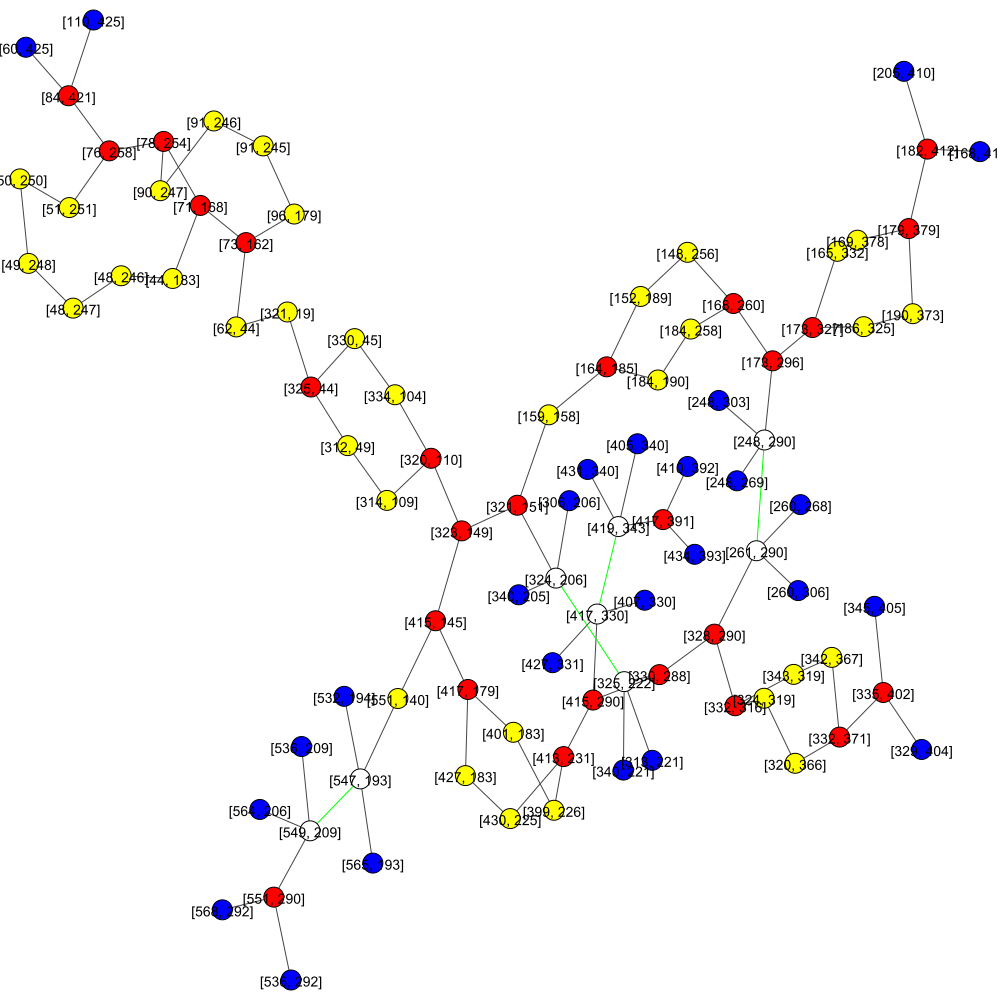

In [6]:
matches = getPatternMatches(union,capPattern(),True) + getPatternMatches(union,resistorPattern(),True) + getPatternMatches(union,groundPattern(),True)
print(matches)
boundingBoxes = list(map(lambda x: generateBoundingBox(x,5),matches))
print(boundingBoxes)

#save graph into file
union.write("out.graph",format="graphml")

layout = union.layout("large_graph")
g.plot(union, layout=layout,bbox=(1000, 1000))

#fig, ax = plt.subplots()
#g.plot(union, layout=layout, target=ax,bbox=(300, 300))

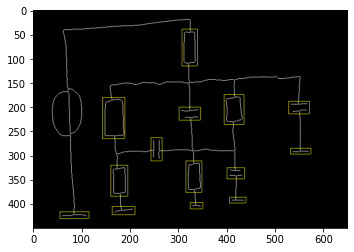

In [7]:
def drawRect(image,boundingBoxes,color):
    corner1 = boundingBoxes[0]
    corner2 = boundingBoxes[1]
    startX = corner1[0]
    startY = corner1[1]

    endX = corner2[0]
    endY = corner2[1]

    for x in range(startX,endX):
        image[startY][x] = color
        image[endY][x] = color

    for y in range(startY,endY):
        image[y][startX] = color
        image[y][endX] = color

    return image


for boundingBox in boundingBoxes:
    drawRect(colorImage,boundingBox,(255,0,0))
colorImage = cv2.cvtColor(255-colorImage, cv2.COLOR_BGR2RGB)
plt.imshow(colorImage,interpolation="bilinear")